In [1]:
import sys

sys.path.insert(0, "/home/m.lavaud/ANDI_2_Challenge_EMetBrown/mamba_segmentation")
# sys.path.insert(0, "/home/m.lavaud/ANDI_2_Challenge_EMetBrown/mamba_regression_alpha")
sys.path.insert(0, "/home/m.lavaud/ANDI_2_Challenge_EMetBrown/mamba_regression_K")
# sys.path.insert(0, "/home/m.lavaud/ANDI_2_Challenge_EMetBrown/mamba_regression_K")
# sys.path.insert(0, "/home/m.lavaud/ANDI_2_Challenge_EMetBrown/segmentation_and_regression")
sys.path.insert(0, "/home/m.lavaud/ANDI_2_Challenge_EMetBrown/simpler_models")


from train_fn import list_directory_tree_with_pathlib

In [2]:
import torch
# from EmetMamba_alpha import EmetMamba as model_alpha
# from EmetMamba_segmentation import EmetMamba as model_segmentation
# from EmetMamba import EmetMamba as model_K
# from EmetMamba_seg_and_regr import EmetMamba as model_seg_reg

In [3]:
# model_alpha = torch.load(
#     "/home/m.lavaud/ANDI_2_Challenge_EMetBrown/mamba_regression_alpha/model_alpha_2_0p1_1e-4_8_8kexps"


In [7]:
from mamba_ssm import Mamba
from einops import rearrange
import torch.nn as nn

In [8]:
class alpha_regression(nn.Module):
    def __init__(self, d_model,d_state,  d_conv, expand,dropout = 0.3, device="cuda"):
        super().__init__()
        self.device = device

        self.mamba = Mamba(d_model = d_model, d_state=d_state, d_conv=d_conv, expand=expand).to(device)
        self.flipped_mamba = Mamba(d_model = d_model, d_state=d_state, d_conv=d_conv, expand=expand).to(device)

        self.dropout = nn.Dropout(p=dropout).to(device)
        self.fc = nn.Linear(in_features = 200*d_model, out_features=2).to(device)

        self.sigmoid = nn.Sigmoid()

    def forward(self, input):

        mamba_out = self.mamba(input)
        mamba_flipped_out = self.flipped_mamba(torch.flip(input, dims=[1]))

        mamba_out = mamba_out + mamba_flipped_out

        mamba_out = rearrange(mamba_out, "b l c -> b (l c)")

        mamba_out = self.dropout(mamba_out)
        out = self.fc(mamba_out)
        return self.sigmoid(out) *2 
    

In [9]:
class K_regression(nn.Module):
    def __init__(self, d_model,d_state,  d_conv, expand,dropout = 0.3, device="cuda"):
        super().__init__()
        self.device = device

        self.mamba = Mamba(d_model = d_model, d_state=d_state, d_conv=d_conv, expand=expand).to(device)
        self.flipped_mamba = Mamba(d_model = d_model, d_state=d_state, d_conv=d_conv, expand=expand).to(device)

        self.dropout = nn.Dropout(p=dropout).to(device)
        self.fc = nn.Linear(in_features = 200*d_model, out_features=2).to(device)

        self.softplus = nn.Softplus()
        
    def forward(self, input):

        mamba_out = self.mamba(input)
        mamba_flipped_out = self.flipped_mamba(torch.flip(input, dims=[1]))

        mamba_out = mamba_out + mamba_flipped_out

        mamba_out = rearrange(mamba_out, "b l c -> b (l c)")

        mamba_out = self.dropout(mamba_out)
        out = self.fc(mamba_out)
        return self.softplus(out)
    


In [11]:
model_segmentation = torch.load(
    "/home/m.lavaud/ANDI_2_Challenge_EMetBrown/mamba_regression_K/model_segmentation_2_0p1_1e-4_4_8kexps"
)
model_K = torch.load(
    "/home/m.lavaud/ANDI_2_Challenge_EMetBrown/simpler_models/K_model"
)

model_alpha = torch.load(
    "/home/m.lavaud/ANDI_2_Challenge_EMetBrown/simpler_models/model_alpha"
)
# model_seg_reg = torch.load("/home/m.lavaud/ANDI_2_Challenge_EMetBrown/segmentation_and_regression/seg_and_reg_fewer_files")

In [12]:
model_alpha.eval()
model_segmentation.eval()
model_K.eval()
# model_seg_reg.eval()

K_regression(
  (mamba): Mamba(
    (in_proj): Linear(in_features=2, out_features=16, bias=False)
    (conv1d): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(2,), groups=8)
    (act): SiLU()
    (x_proj): Linear(in_features=8, out_features=3, bias=False)
    (dt_proj): Linear(in_features=1, out_features=8, bias=True)
    (out_proj): Linear(in_features=8, out_features=2, bias=False)
  )
  (flipped_mamba): Mamba(
    (in_proj): Linear(in_features=2, out_features=16, bias=False)
    (conv1d): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(2,), groups=8)
    (act): SiLU()
    (x_proj): Linear(in_features=8, out_features=3, bias=False)
    (dt_proj): Linear(in_features=1, out_features=8, bias=True)
    (out_proj): Linear(in_features=8, out_features=2, bias=False)
  )
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=400, out_features=2, bias=True)
  (softplus): Softplus(beta=1.0, threshold=20.0)
)

In [13]:
data_path = "track_2/"
directory_files = list_directory_tree_with_pathlib(data_path)

In [19]:
import pandas as pd
import numpy as np


def apply_padding(data_df):
    # Define the finaT_l shape of the data and labels
    T_max = 200
    selected_ids = data_df["traj_idx"].unique()

    final_shape = (len(selected_ids), T_max, 3)

    # Initialize the final data and labels with zeros
    final_data = np.zeros(final_shape)

    # Iterate over the selected trajectory indices
    for n, id in enumerate(selected_ids):
        # Filter the data for the current trajectory index
        exp = data_df[data_df["traj_idx"] == id]

        # Extract the data and labels for the current trajectory
        data = exp[["frame", "x", "y"]].to_numpy()
        # print(exp["frame"])
        data[:,0] = data[:,0] - data[0,0] + 1 #set first frame at 1
        data[:,1] = data[:,1] - data[0,1]  ## Set x and y at 0
        data[:,2] = data[:,2] - data[0,2] 
        # If the data is longer than T_max, truncate it
        if data.shape[0] > T_max:

            final_data[n, :, :] = data[:T_max, :]

        # Otherwise, pad the data to T_max
        else:
            # print((label.shape, T_max))
            final_data[n, : data.shape[0], :] = data
    # Return the padded data and labels
    return final_data

In [22]:
def read_dataset(file):
    df = pd.read_csv(file)
    nb_trajs = len(df["traj_idx"].unique())
    # dataset = np.zeros((np.ceil(nb_trajs/20).astype(int), 20, 200,3))

    df_padded = apply_padding(df)
    df_padded = df_padded[:, :, 1:]
    # if nb_trajs % 20 == 0:

    #     for i in range(dataset.shape[0]):
    #         dataset[i,:,:,:] = df_padded[i*20:(i+1)*20, :,:]

    # else :
    #     for i in range(dataset.shape[0] - 1):
    #         dataset[i,:,:,:] = df_padded[i*20:(i+1)*20, :,:]

    #     #On place i dans la dernière couche
    #     i+=1
    #     remaining_trajs = nb_trajs % 20
    #     dataset[i,:remaining_trajs,:,:] = df_padded[-remaining_trajs:, :, :]
    #     dataset[i,remaining_trajs:,:,:] = df_padded[:(20 - remaining_trajs), :, :]

    return torch.from_numpy(df_padded.astype(np.float32))

In [23]:
results_alpha = {}
results_K = {}
# results_segmentation = {}

with torch.no_grad():
    for file in directory_files:
        data = read_dataset(file)
        data = data.to("cuda")
        results_alpha[file] = model_alpha(data).squeeze()
        results_K[file] = model_K(data).squeeze()
        # results_segmentation[file] = torch.argmax(
        #     model_segmentation(data[:, :, 1:]).squeeze(), dim=-1
        # )

        # segmentation, alpha, K = model_seg_reg(data)
        # results_alpha[file] = alpha.squeeze()
        # results_K[file] = K.squeeze()
        # results_segmentation[file] = torch.argmax(segmentation.squeeze(), dim=-1)

        

In [24]:
keys = list(results_alpha.keys())

In [25]:
import matplotlib.pyplot as plt

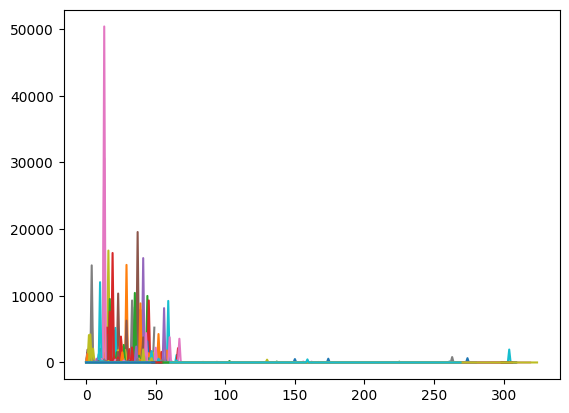

In [27]:
for i in keys:
    K = results_K[i].to("cpu")
    plt.plot(K[:, 0])

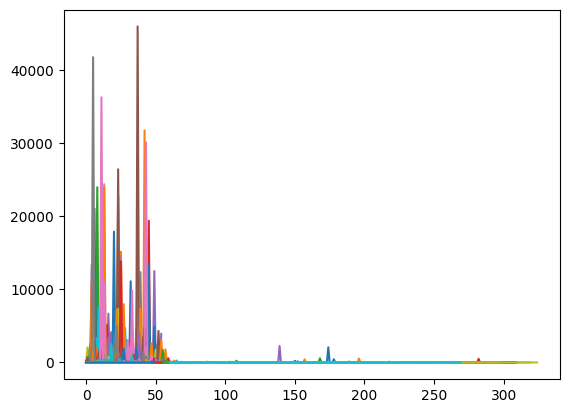

In [28]:
j = 0
for i in keys:
    K = results_K[i].to("cpu")
    plt.plot(K[:, 1])
    j += len(K[:, 1])

In [29]:
results_alpha

{PosixPath('track_2/exp_10/trajs_fov_29.csv'): tensor([[1.3833e-01, 1.2035e-01],
         [4.0413e-01, 4.0029e-01],
         [3.2220e-01, 2.6286e-01],
         [3.6298e-01, 3.1626e-01],
         [2.1738e-01, 2.4323e-01],
         [9.4073e-02, 8.4429e-02],
         [1.3740e+00, 1.3483e+00],
         [1.8786e+00, 1.9105e+00],
         [1.9772e-02, 2.0050e-02],
         [4.3654e-04, 8.4641e-04],
         [1.4076e-01, 1.6086e-01],
         [2.6214e-13, 1.1905e-14],
         [1.1667e+00, 1.2020e+00],
         [8.3751e-01, 9.8331e-01],
         [2.6566e-03, 2.1578e-03],
         [4.6418e-06, 4.2744e-06],
         [1.4035e+00, 1.2492e+00],
         [6.3064e-01, 6.5177e-01],
         [1.4869e-01, 1.5227e-01],
         [1.9990e+00, 1.9981e+00],
         [5.1711e-01, 6.5242e-01],
         [4.6523e-03, 1.1344e-02],
         [1.5355e+00, 1.5649e+00],
         [1.4732e+00, 1.5643e+00],
         [4.4602e-01, 2.7184e-01],
         [1.1486e+00, 1.0244e+00],
         [2.0000e+00, 2.0000e+00],
         

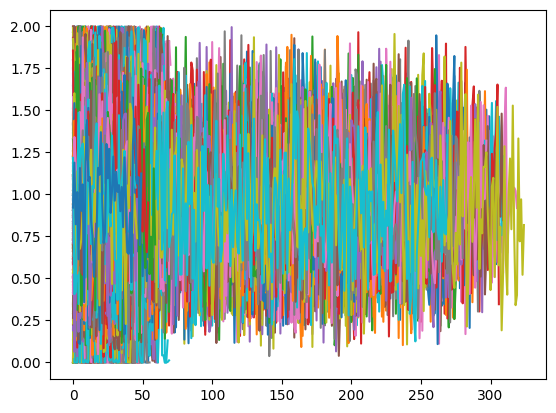

In [30]:
for i in keys:
    alpha = results_alpha[i].to("cpu")
    plt.plot(alpha[:, 0])

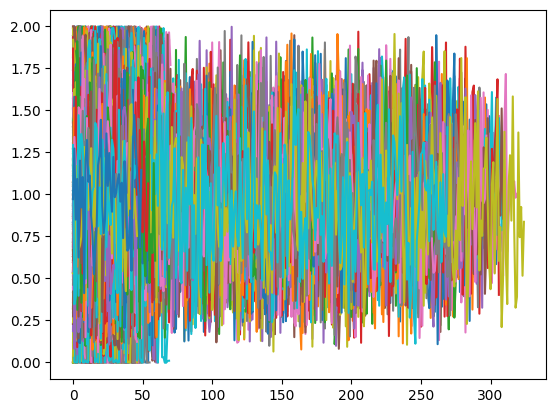

In [31]:
for i in keys:
    alpha = results_alpha[i].to("cpu")
    plt.plot(alpha[:, 1])

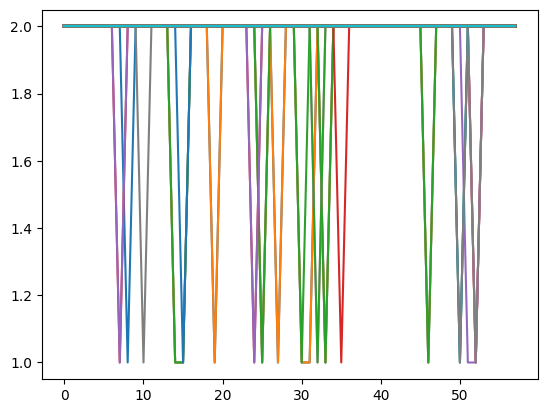

In [32]:
liste_unique = []
plt.figure()
for i in keys[:1]:

    segmentation = results_segmentation[i].to("cpu")
    plt.plot(segmentation)
    # a = len(np.unique(results_segmentation))
    # liste_unique.append(a)

# plt.plot(liste_unique)

In [33]:
results_segmentation[i].to("cpu").size()

torch.Size([58, 200])

In [34]:
file

PosixPath('track_2/exp_5/.ipynb_checkpoints/trajs_fov_1-checkpoint.csv')

In [35]:
results_alpha[file]

tensor([[0.9218, 0.9722],
        [1.1893, 1.2735],
        [0.8225, 0.8502],
        [1.0139, 1.0925],
        [0.6141, 0.6251],
        [1.1577, 1.2014],
        [0.9029, 0.9228],
        [1.0600, 1.1039],
        [0.3588, 0.4130],
        [1.1983, 1.2085],
        [1.4425, 1.3245],
        [1.0804, 1.0761],
        [1.1042, 1.1122],
        [0.8426, 0.8719],
        [0.7554, 0.7661],
        [0.5105, 0.5260],
        [0.6741, 0.6771],
        [0.7968, 0.8102],
        [1.1586, 1.1727],
        [1.1169, 1.2314],
        [1.3709, 1.4446],
        [0.9589, 0.9370],
        [0.7120, 0.7688],
        [0.7718, 0.8531],
        [1.3005, 1.3635],
        [1.0966, 1.0510],
        [1.2718, 1.2468],
        [0.8905, 1.0215],
        [1.0202, 0.8972],
        [1.2258, 1.2234],
        [0.9630, 0.9840],
        [1.1346, 1.0110],
        [1.0155, 1.0801],
        [1.0556, 1.1208],
        [0.9003, 0.9574],
        [1.0447, 1.0698],
        [0.8053, 0.7400],
        [1.2209, 1.1978],
        [0.9

In [36]:
df = pd.read_csv(file)

In [37]:
df

,traj_idx,frame,x,y
0,0.0,0.0,161.164267,142.763482
1,0.0,1.0,161.077403,142.589036
2,0.0,2.0,161.354558,143.874786
3,0.0,3.0,161.169485,143.458609
4,0.0,4.0,159.270483,143.829008
...,...,...,...,...
6544,49.0,195.0,98.579725,116.656936
6545,49.0,196.0,98.723755,116.624656
6546,49.0,197.0,95.746428,116.273580
6547,49.0,198.0,95.677146,116.151651


In [38]:
def generate_solution(file):
    
    df = pd.read_csv(file)

    total_sol = ""
    for id, group in df.groupby("traj_idx"):
        sol=""

        states = results_segmentation[file][int(id)].to("cpu") - 1
        alphas = results_alpha[file][int(id)].to("cpu")
        Ds = results_K[file][int(id)].to("cpu")
        unique_states = np.unique(states)
        
        if len(unique_states) == 1:
            
            if alphas[0] < 0.01:
                state = 1
            elif alphas[0] > 1.8:
                state = 3
            else:
                state = 2

            total_sol+= f"{int(id)},{Ds[0]},{alphas[0]},{state},{len(group["x"])}\n"
        else:

            state = [0,0]
            if alphas[0] < 0.001:
                state[0] = 1
            elif alphas[0] > 1.8:
                state[0] = 3
            else:
                state[0] = 2

            if alphas[1] < 0.001:
                state[1] = 1
            elif alphas[1] > 1.8:
                state[1] = 3
            else:
                state[1] = 2

            if Ds[0] < 1e-7:
                Ds[0] = 0
            if Ds[1] < 1e-7:
                Ds[1] = 0


            init_state = int(states[0])
            sol = f"{int(id)},{Ds[init_state]},{alphas[init_state]},{state[init_state]},"

            for i in range(len(group["frame"])):
                if int(states[i]) != init_state:
                    init_state = (init_state + 1) % 2
                    sol += f"{int(group["frame"].iloc[i])},{Ds[init_state]},{alphas[init_state]},{state[init_state]},"
            sol+=f"{len(group["x"])}\n"
            total_sol+=sol

    return total_sol

In [39]:
dict_solutions = {}
j=0
for i in keys:
    j=0
    dict_solutions[i] = generate_solution(i)

In [40]:
keys = list(dict_solutions.keys())

In [41]:
print(generate_solution(keys[5]))

0,1.131372332572937,1.4218014478683472,2,83,0.16324393451213837,1.402786374092102,2,86,1.131372332572937,1.4218014478683472,2,87,0.16324393451213837,1.402786374092102,2,88,1.131372332572937,1.4218014478683472,2,89,0.16324393451213837,1.402786374092102,2,95,1.131372332572937,1.4218014478683472,2,96,0.16324393451213837,1.402786374092102,2,102,1.131372332572937,1.4218014478683472,2,104,0.16324393451213837,1.402786374092102,2,105,1.131372332572937,1.4218014478683472,2,109,0.16324393451213837,1.402786374092102,2,110,1.131372332572937,1.4218014478683472,2,54
1,1034.48388671875,1.593371033668518,2,146,0.0,1.412204623222351,2,147,1034.48388671875,1.593371033668518,2,159,0.0,1.412204623222351,2,160,1034.48388671875,1.593371033668518,2,163,0.0,1.412204623222351,2,165,1034.48388671875,1.593371033668518,2,166,0.0,1.412204623222351,2,168,1034.48388671875,1.593371033668518,2,169,0.0,1.412204623222351,2,56
2,0.00019253329082857817,2.3394186143832485e-08,1,2,0.0,2.169195134626989e-08,1,3,0.00019253329

In [44]:
from copy import copy
from pathlib import Path

In [45]:
for i in keys:
    key = copy(i)
    file_name = i.parts[-1][6:-4] + ".txt"
    total_path = Path(*["solution", *i.parts[-3:-1],file_name])
    folder_path = Path(*total_path.parts[:-1])
    folder_path.mkdir(parents=True, exist_ok=True)

    with open(total_path, "w") as file:
        file.write(dict_solutions[key])


In [148]:
total_path

PosixPath('solution/track_2/exp_2/fov_18.txt')

In [134]:
dict_solutions[keys[0]]

'0, 0.0, 0.0, 1, 153\n1, 0.0, 0.0, 1, 26\n2, 0.0, 0.0, 1, 200\n3, 0.0, 0.0, 1, 200\n4, 0.0, 0.0, 1, 200\n5, 0.0, 0.0, 13.0, 0.0, 0.0, 1, 56\n6, 0.0, 0.0, 1179.0, 0.0, 0.0, 1, 180.0, 0.0, 0.0, 1, 22\n7, 0.0, 0.0, 1, 67\n8, 0.0, 0.0, 1, 200\n9, 0.0, 0.0, 185.0, 0.0, 0.0, 1, 52\n10, 0.0, 0.0, 1, 61\n11, 0.0, 0.0, 1, 111\n12, 0.0, 0.0, 1, 200\n13, 0.0, 0.0, 1, 200\n14, 0.0, 0.0, 13.0, 0.0, 0.0, 1, 200\n15, 0.0, 0.0, 1, 188\n16, 0.0, 0.0, 1, 200\n17, 0.0, 0.0, 1, 200\n18, 0.0, 0.0, 1, 200\n19, 0.0, 0.0, 1, 122\n20, 0.0, 0.0, 1, 43\n21, 0.0, 0.0, 1, 200\n22, 0.0, 0.0, 13.0, 0.0, 0.0, 1, 200\n23, 0.0, 0.0, 1, 136\n24, 0.0, 0.0, 13.0, 0.0, 0.0, 1, 200\n25, 0.0, 0.0, 1, 51\n26, 0.0, 0.0, 1, 144\n27, 0.0, 0.0, 1, 200\n28, 0.0, 0.0, 1, 200\n29, 0.0, 0.0, 1, 25\n30, 0.0, 0.0, 1, 24\n31, 0.0, 0.0, 1, 24\n32, 0.0, 0.0, 1, 200\n33, 0.0, 0.0, 1, 109\n34, 0.0, 0.0, 1, 34\n35, 0.0, 0.0, 1, 20\n36, 0.0, 0.0, 1, 23\n37, 0.0, 0.0, 1, 51\n38, 0.0, 0.0, 1, 200\n39, 0.0, 0.0, 1, 20\n40, 0.0, 0.0, 13.0, 0.0, 0

In [135]:
generate_solution(key)

'0, 0.027150867506861687, 0.027150867506861687, 2, 200\n1, 0.0268391165882349, 0.0268391165882349, 2, 200\n2, 0.026789465919137, 0.026789465919137, 2, 200\n3, 0.026789465919137, 0.026789465919137, 22.0, 0.02761705592274666, 0.02761705592274666, 2, 200\n4, 0.026841487735509872, 0.026841487735509872, 2, 200\n5, 0.026789465919137, 0.026789465919137, 22.0, 0.02761705592274666, 0.02761705592274666, 2, 200\n6, 0.026789465919137, 0.026789465919137, 2, 200\n7, 0.026789465919137, 0.026789465919137, 2, 200\n8, 0.026778608560562134, 0.026778608560562134, 2, 200\n9, 0.026789465919137, 0.026789465919137, 2, 200\n10, 0.026789465919137, 0.026789465919137, 21.0, 0.02761705592274666, 0.02761705592274666, 2, 200\n11, 0.026789465919137, 0.026789465919137, 2, 200\n12, 0.026789465919137, 0.026789465919137, 2, 200\n13, 0.026789465919137, 0.026789465919137, 2, 23\n14, 0.026854775846004486, 0.026854775846004486, 2, 200\n15, 0.026789465919137, 0.026789465919137, 2, 105\n16, 0.026789465919137, 0.026789465919137

In [131]:
pd.read_csv(key)

,traj_idx,frame,x,y
0,0.0,0.0,86.718445,146.393070
1,0.0,1.0,85.964687,145.933155
2,0.0,2.0,86.755880,146.217936
3,0.0,3.0,85.885044,145.486404
4,0.0,4.0,86.544656,146.468725
...,...,...,...,...
5541,30.0,195.0,58.513736,148.735369
5542,30.0,196.0,58.047409,149.668565
5543,30.0,197.0,59.068283,148.871918
5544,30.0,198.0,58.337647,148.232191
